In [1]:
import dlib
import numpy as np
import cv2
import sys
import os
import glob
import matplotlib.pyplot as plt

In [2]:
# config
root_path = r'E:/ml/Facial_Keypoint_Detection'
predictor_path = root_path + '/predictor/shape_predictor_68_face_landmarks.dat'
faces_folder_path = root_path + '/img'
results_path = root_path + '/results/'
# print(dlib.__version__)

In [3]:
# if you directly save the img using plt.savefig, you will get the img with white paddings
# this method save the img without any white space
def save_image(data, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
     
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
 
    ax.imshow(data)
    plt.savefig(fn, dpi = height) 
    plt.close()

In [5]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
win = dlib.image_window()

# get the detection resuluts and landmarks from the img
# save the landmarks in the corresponding npy file
for f in glob.glob(os.path.join(faces_folder_path, "*.png")):
    print("Processing file: {}".format(f))
    img = cv2.imread(f)
    img = img[:, :, ::-1]

    win.clear_overlay()
    win.set_image(img)
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))
    for k, d in enumerate(dets):
        shape = predictor(img, d)
        points = []
        for i in range(68):
            points.append((shape.part(i).x, shape.part(i).y))
        points = np.array(points)
        filename = f.split('\\')[-1].split('.')[0] + '.npy'
        pointspath = 'points/' + filename
        np.save(pointspath, points)
        win.add_overlay(shape)
    win.add_overlay(dets)
    dlib.hit_enter_to_continue()

Processing file: E:/ml/Facial_Keypoint_Detection/img\test.png
Number of faces detected: 1


In [6]:
process_error = []
# read the landmarks from npy files
# use the landmarks to generate heatmap and save it in the results
# at the same time process the error img because the detector can't detect faces in some imgs
for f in glob.glob(os.path.join(faces_folder_path, "*.png")):
    filename = f.split('\\')[-1].split('.')[0]
    pointspath = 'points/' + filename + '.npy'
    try:
        points = np.load(pointspath)
    except FileNotFoundError:
        print("An error occurs when processing " + filename + '.png ')
        process_error.append(filename+'.png')
        continue
    if len(process_error) >= 15:
        with open('error.txt', mode='a+') as p:
            for i in process_error:
                p.write(i + '\n')
        process_error = []
    img = cv2.imread(f)
    img = img[:, :, ::-1]
    h = np.arange(0, img.shape[0])
    w = np.arange(0, img.shape[1])
    gridh, gridw = np.meshgrid(w, h)
    grids = np.vstack([gridh.ravel(), gridw.ravel()]).T
    points = points[:, np.newaxis, :]
    grids = grids[np.newaxis, :, :]
    grids = grids.repeat(68, axis=0)
    dx = (grids[:, :, 0] - points[:, :, 0]) ** 2
    dy = (grids[:, :, 1] - points[:, :, 1]) ** 2
    Gxy = (1.0 / (np.pi * 2)) * np.exp(-(dx + dy) / 2.0)
    heatmap = np.sum(Gxy, axis=0)
    heatmap = heatmap.reshape(*img.shape[:2])
    save_image(data=heatmap, fn=results_path + filename + '.png')
with open('error.txt', mode='a+') as p:
    for i in process_error:
        p.write(i + '\n')

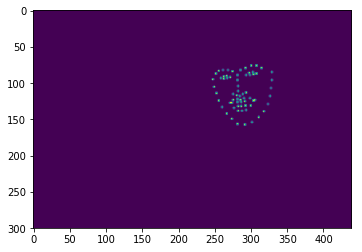

In [7]:
# test the result
for f in glob.glob(os.path.join(results_path, "*.png")):
    img = cv2.imread(f)
    img = img[:, :, ::-1]
    plt.imshow(img)
    plt.show()